In [51]:
# Import library dasar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Konfigurasi untuk plot yang lebih baik
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Data Preparation

A. Data Generation atau Loading

In [52]:
# Menjamin hasil yang sama ketika re run code
np.random.seed(42)

# Jumlah sampel data
n_samples = 200

# Generate dataset
luas_tanah = np.random.uniform(50, 500, n_samples)
luas_bangunan = np.random.uniform(30, 400, n_samples)
jumlah_kamar = np.random.randint(1, 6, n_samples)
umur_bangunan = np.random.randint(0, 31, n_samples)
jarak_ke_pusat_kota = np.random.uniform(1, 20, n_samples)

# Harga meningkat tajam dengan luas bangunan
# Harga sedikit menurun dengan umur dan jarak
# Noise untuk membuat dataset lebih realistik
harga_properti = (
    250 +
    (luas_bangunan * 8) +
    (luas_tanah * 2) +
    (luas_bangunan**1.5 * 0.5) - # Hubungan non-linear
    (umur_bangunan * 5) -
    (jarak_ke_pusat_kota * 10) +
    (jumlah_kamar * 50) +
    np.random.normal(0, 200, n_samples) # Noise
)

# Target Y dalam range 200 - 5000
harga_properti = np.clip(harga_properti, 200, 5000)


# Buat DataFrame
data = {
    'Luas Tanah (m²)' : luas_tanah,
    'Luas Bangunan (m²)' : luas_bangunan,
    'Jumlah Kamar Tidur' : jumlah_kamar,
    'Umur Bangunan (tahun)' : umur_bangunan,
    'Jarak ke Pusat Kota (km)' : jarak_ke_pusat_kota,
    'Harga Properti (juta Rp)' : harga_properti
}
df = pd.DataFrame(data)

# Simpan ke file CSV
df.to_csv('dataset_properti.csv', index=False)

print("Dataset berhasil dibuat dengan shape:", df.shape)
df.head()

Dataset berhasil dibuat dengan shape: (200, 6)


,Luas Tanah (m²),Luas Bangunan (m²),Jumlah Kamar Tidur,Umur Bangunan (tahun),Jarak ke Pusat Kota (km),Harga Properti (juta Rp)
0,218.543053,267.551709,1,30,7.746982,4722.539894
1,477.821438,61.131787,1,7,13.327634,1633.294263
2,379.397274,89.802624,1,6,10.112060,1897.425914
3,319.396318,362.465050,4,25,12.099790,5000.000000
4,120.208388,254.378752,1,25,14.999627,4598.967308


B. Exploratory Data Analysis (EDA)

Ringkasan Statistik:
       Luas Tanah (m²)  Luas Bangunan (m²)  Jumlah Kamar Tidur  \
count       200.000000          200.000000          200.000000   
mean        267.802805          216.618800            3.105000   
std         132.701144          108.410441            1.515075   
min          52.484953           31.872786            1.000000   
25%         152.862087          126.741125            2.000000   
50%         272.518814          230.406755            3.000000   
75%         390.586827          304.613746            5.000000   
max         494.099121          396.486903            5.000000   

       Umur Bangunan (tahun)  Jarak ke Pusat Kota (km)  \
count             200.000000                200.000000   
mean               15.920000                 10.767737   
std                 8.890942                  5.317921   
min                 0.000000                  1.051507   
25%                 9.000000                  6.171691   
50%                16.000000        

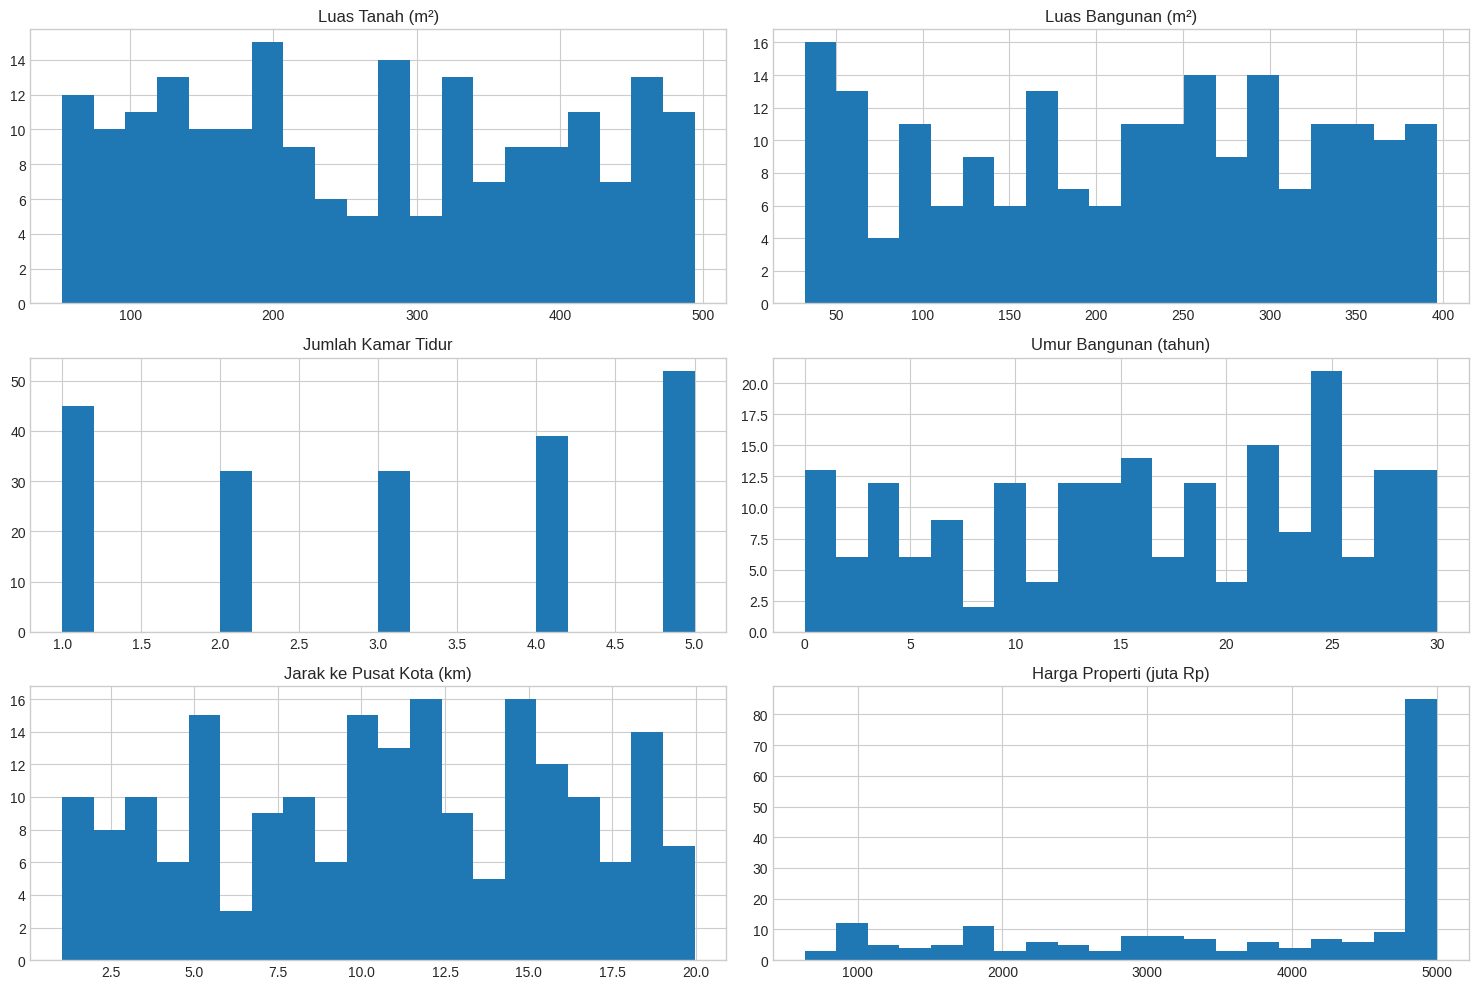


Scatter Plot Fitur vs Harga:


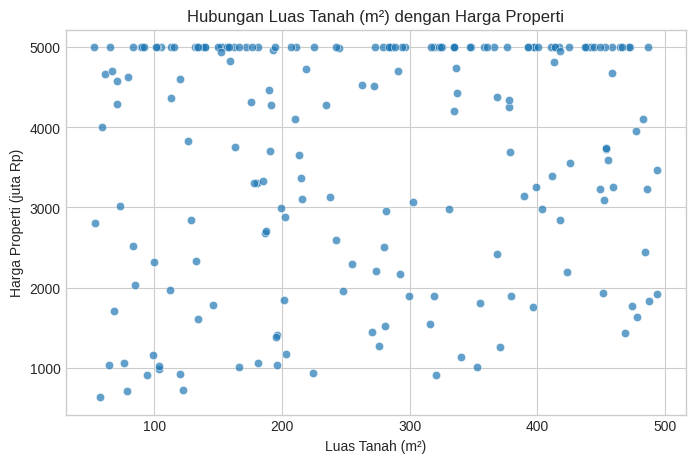

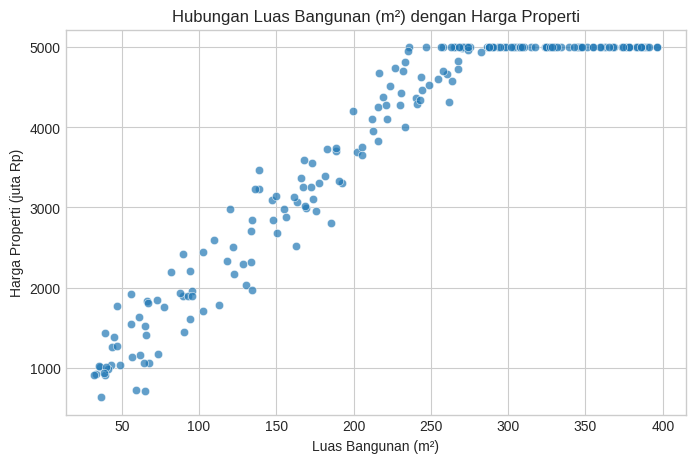

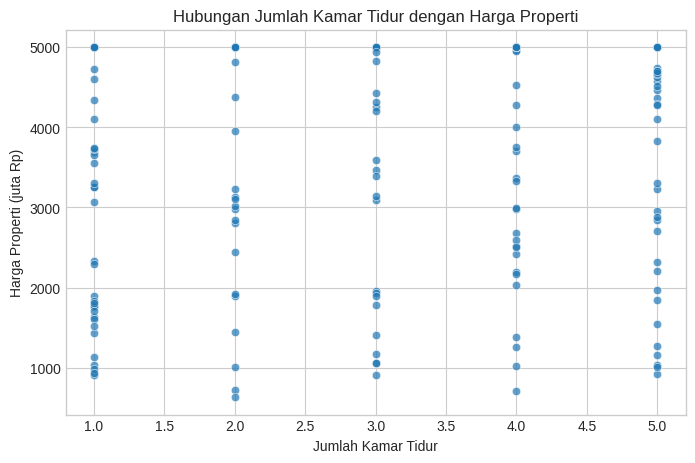

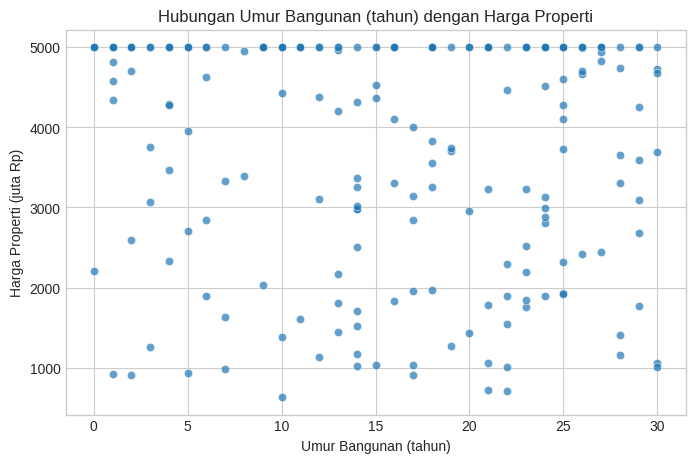

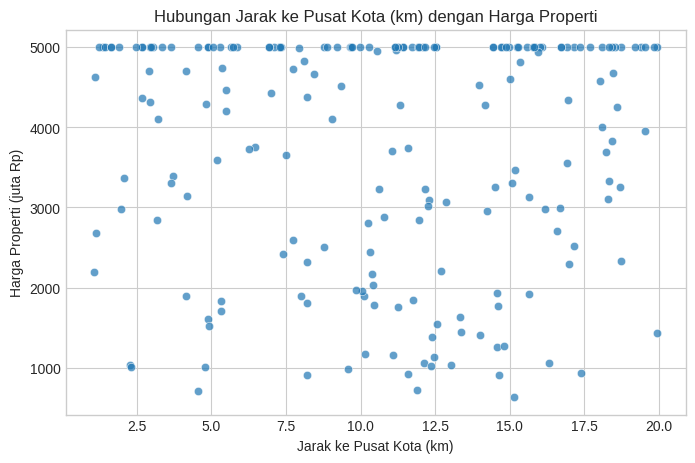


Heatmap Korelasi:


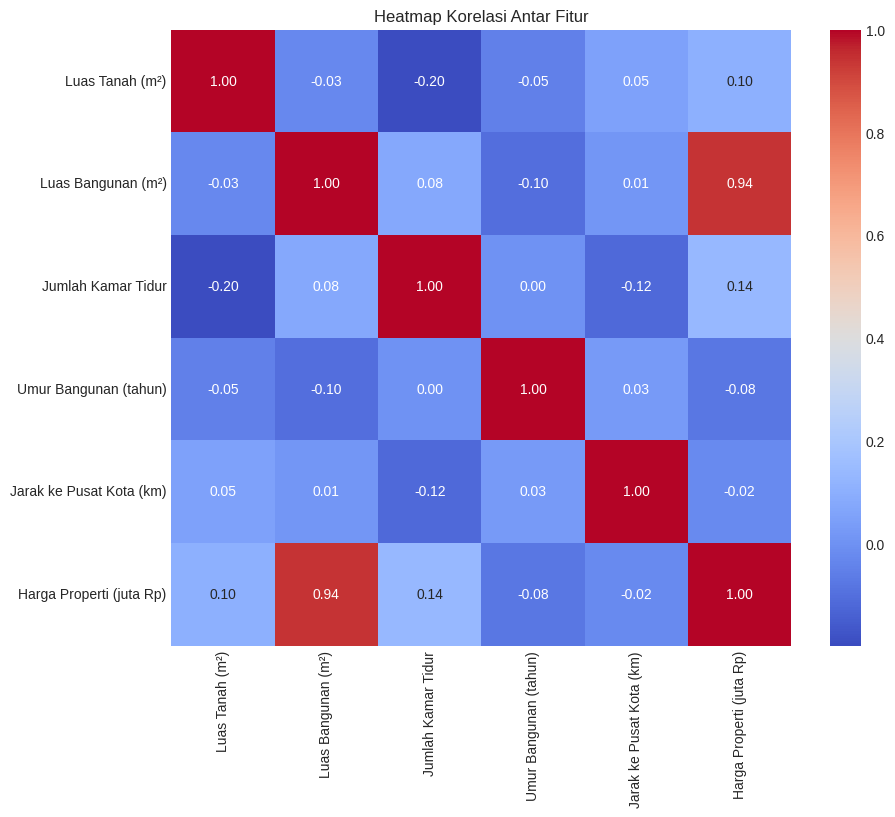

In [53]:
# statistical summary
print("Ringkasan Statistik:")
print(df.describe())

# Visualisasi distribusi setiap fitur (histogram)
print("Distribusi Setiap Fitur:")
df.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Scatter plot setiap fitur vs harga
print("\nScatter Plot Fitur vs Harga:")
features = df.columns[:-1]
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=feature, y='Harga Properti (juta Rp)', alpha=0.7)
    plt.title(f'Hubungan {feature} dengan Harga Properti')
    plt.show()

# Correlation matrix (heatmap)
print("\nHeatmap Korelasi:")
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

C. Data Preprocessing

In [54]:
# Pisahkan fitur (X) dan target (y)
X = df.drop('Harga Properti (juta Rp)', axis=1)
y = df['Harga Properti (juta Rp)']

# Split data menjadi training (70%) dan testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Ukuran data training: {X_train.shape}")
print(f"Ukuran data testing: {X_test.shape}")

# Feature scaling menggunakan StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan scaler untuk digunakan nanti saat prediksi data baru
joblib.dump(scaler, 'scaler.pkl')
print("\nScaler berhasil disimpan ke 'scaler.pkl'")

pd.DataFrame(X_train_scaled, columns=X.columns).head()

Ukuran data training: (140, 5)
Ukuran data testing: (60, 5)

Scaler berhasil disimpan ke 'scaler.pkl'


,Luas Tanah (m²),Luas Bangunan (m²),Jumlah Kamar Tidur,Umur Bangunan (tahun),Jarak ke Pusat Kota (km)
0,0.355584,-1.400688,1.235591,0.658236,0.415402
1,-0.198471,-0.912838,0.567704,-1.628439,-0.473519
2,-1.070217,0.042534,1.235591,0.200901,1.504857
3,1.174869,0.539926,-1.435957,-1.857107,-0.864276
4,1.093313,0.774727,-0.768070,-1.742773,0.820212


## 2. Model Implementation

A. Polynomial Feature Engineering

In [55]:
# Looping untuk setiap derajat polinomial
for degree in range(1, 6):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    print(f"Degree {degree}:")
    print(f"  Jumlah fitur asli: {X_train_scaled.shape[1]}")
    print(f"  Jumlah fitur setelah transformasi polinomial: {X_train_poly.shape[1]}")

Degree 1:
  Jumlah fitur asli: 5
  Jumlah fitur setelah transformasi polinomial: 5
Degree 2:
  Jumlah fitur asli: 5
  Jumlah fitur setelah transformasi polinomial: 20
Degree 3:
  Jumlah fitur asli: 5
  Jumlah fitur setelah transformasi polinomial: 55
Degree 4:
  Jumlah fitur asli: 5
  Jumlah fitur setelah transformasi polinomial: 125
Degree 5:
  Jumlah fitur asli: 5
  Jumlah fitur setelah transformasi polinomial: 251


B. Model Training

In [56]:
models = {}
alphas = [0.1, 1, 10]

for degree in range(1, 6):
    # Buat fitur polinomial untuk derajat saat ini
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train_scaled)

    # Linear Regression Biasa
    model_name = f'Degree {degree} - Linear'
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_poly, y_train)
    models[model_name] = {'model': lin_reg, 'poly_features': poly_features}

    # Ridge Regression
    for alpha in alphas:
        model_name = f'Degree {degree} - Ridge (alpha={alpha})'
        ridge_reg = Ridge(alpha=alpha, max_iter=10000)
        ridge_reg.fit(X_train_poly, y_train)
        models[model_name] = {'model': ridge_reg, 'poly_features': poly_features}

    # Lasso Regression
    for alpha in alphas:
        model_name = f'Degree {degree} - Lasso (alpha={alpha})'
        lasso_reg = Lasso(alpha=alpha, max_iter=10000)
        lasso_reg.fit(X_train_poly, y_train)
        models[model_name] = {'model': lasso_reg, 'poly_features': poly_features}

print(f"Total model yang dilatih: {len(models)}")
print("Contoh nama model:", list(models.keys())[0])

Total model yang dilatih: 35
Contoh nama model: Degree 1 - Linear


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.309e+04, tolerance: 3.092e+04
  model = cd_fast.enet_coordinate_descent(


## 3. Model Evaluation

A. Metrics Calculation

In [57]:
#Function Metrics Calculation
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'R²': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape}

results = []

for name, model_info in models.items():
    model = model_info['model']
    poly = model_info['poly_features']

    # Transformasi data train dan test
    X_train_poly = poly.transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Prediksi
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    # Hitung metrik
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)

    results.append({
        'Model': name,
        'Train R²': train_metrics['R²'],
        'Test R²': test_metrics['R²'],
        'Train RMSE': train_metrics['RMSE'],
        'Test RMSE': test_metrics['RMSE']
    })


results_df = pd.DataFrame(results)
results_df.sort_values(by='Test R²', ascending=False).style.background_gradient(cmap='viridis')

,Model,Train R²,Test R²,Train RMSE,Test RMSE
20,Degree 3 - Lasso (alpha=10),0.985797,0.972914,177.119169,222.479975
19,Degree 3 - Lasso (alpha=1),0.989754,0.969914,150.432113,234.476994
16,Degree 3 - Ridge (alpha=1),0.988584,0.969789,158.789149,234.965514
27,Degree 4 - Lasso (alpha=10),0.987195,0.967833,168.173673,242.451750
34,Degree 5 - Lasso (alpha=10),0.989132,0.965252,154.932629,251.992109
15,Degree 3 - Ridge (alpha=0.1),0.989883,0.964286,149.487616,255.469363
18,Degree 3 - Lasso (alpha=0.1),0.989898,0.963835,149.372326,257.076952
14,Degree 3 - Linear,0.989900,0.962893,149.358354,260.404178
13,Degree 2 - Lasso (alpha=10),0.975400,0.955225,233.098033,286.046952
12,Degree 2 - Lasso (alpha=1),0.976522,0.953123,227.720595,292.684480


B. Overfitting & Underfitting Analysis

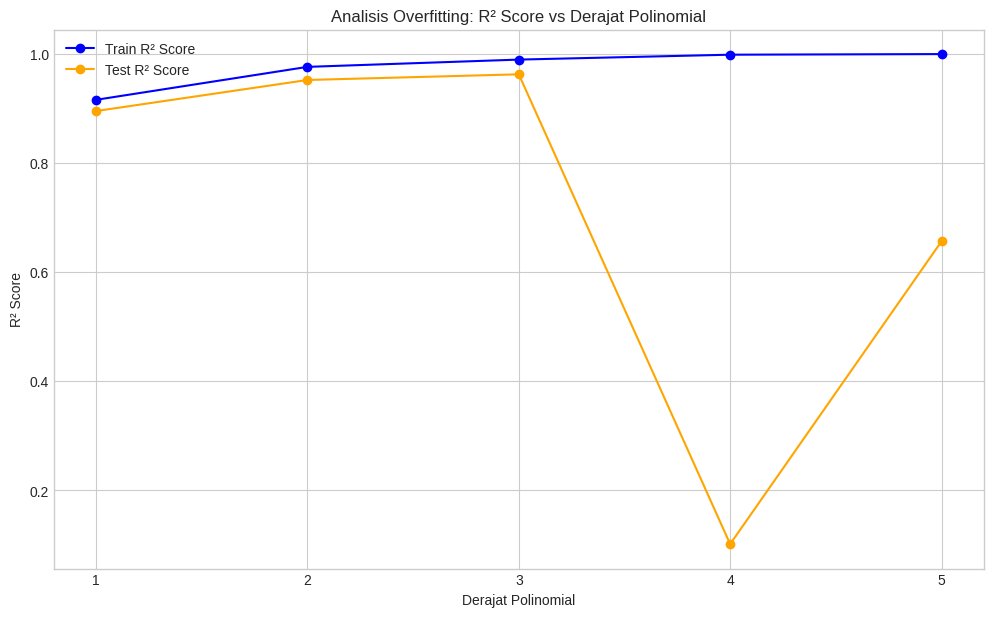

In [58]:
# Ekstrak hasil untuk model Linear Regression biasa di setiap derajat
linear_results = results_df[results_df['Model'].str.contains('Linear')]
degrees = [int(s.split(' ')[1]) for s in linear_results['Model']]

plt.figure(figsize=(12, 7))
plt.plot(degrees, linear_results['Train R²'], 'o-', label='Train R² Score', color='blue')
plt.plot(degrees, linear_results['Test R²'], 'o-', label='Test R² Score', color='orange')
plt.xlabel('Derajat Polinomial')
plt.ylabel('R² Score')
plt.title('Analisis Overfitting: R² Score vs Derajat Polinomial')
plt.xticks(degrees)
plt.legend()
plt.grid(True)
plt.show()

Analisis Bias–Variance Trade-off

Degree 1 (Underfitting):
Model pada derajat ini masih terlalu sederhana sehingga belum mampu menangkap pola hubungan antar variabel dengan baik. Nilai R² pada data training maupun testing relatif rendah. Kondisi ini mencerminkan high bias, yaitu kesalahan akibat model yang terlalu kaku dan kurang fleksibel.

Degree 2 (Optimal):
Pada derajat ini, nilai R² untuk training dan testing sama-sama tinggi serta tidak memiliki perbedaan yang signifikan. Hal ini menunjukkan bahwa model sudah cukup mampu memahami pola data tanpa kehilangan kemampuan generalisasi. Dengan kata lain, model berada dalam kondisi seimbang antara bias dan varians (low bias, low variance).

Degree 3, 4, dan 5 (Overfitting):
Pada derajat yang lebih tinggi, nilai R² pada data training meningkat hingga mendekati 1.0, tetapi nilai R² pada data testing justru menurun drastis. Perbedaan yang besar antara kedua nilai tersebut menandakan terjadinya high variance, di mana model terlalu menyesuaikan diri terhadap data latih sehingga gagal memprediksi data baru dengan baik.

C. Visualization

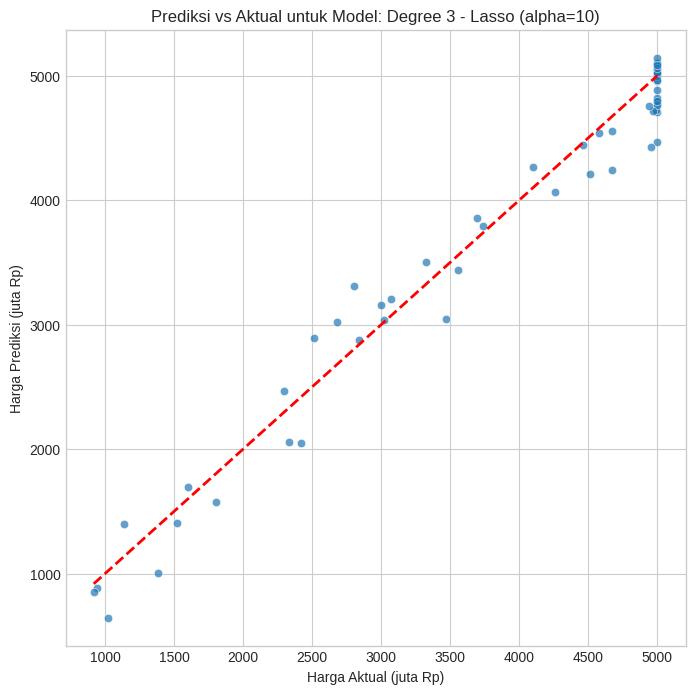

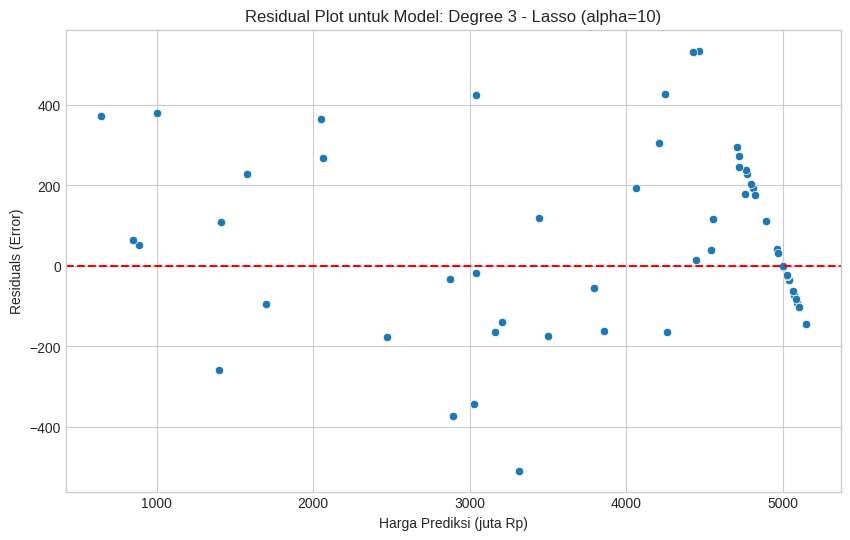

In [59]:
# model terbaik sementara (berdasarkan R² tertinggi di test set)
best_model_name = results_df.sort_values(by='Test R²', ascending=False).iloc[0]['Model']
best_model_info = models[best_model_name]
best_model = best_model_info['model']
best_poly = best_model_info['poly_features']

# Transformasi test data
X_test_poly_best = best_poly.transform(X_test_scaled)
y_pred_best = best_model.predict(X_test_poly_best)

# Plot Predicted vs Actual Values
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Harga Aktual (juta Rp)')
plt.ylabel('Harga Prediksi (juta Rp)')
plt.title(f'Prediksi vs Aktual untuk Model: {best_model_name}')
plt.show()

# Residual Plot
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Harga Prediksi (juta Rp)')
plt.ylabel('Residuals (Error)')
plt.title(f'Residual Plot untuk Model: {best_model_name}')
plt.show()

## 4. Regularization Analysis

A. Ridge vs Lasso Comparison

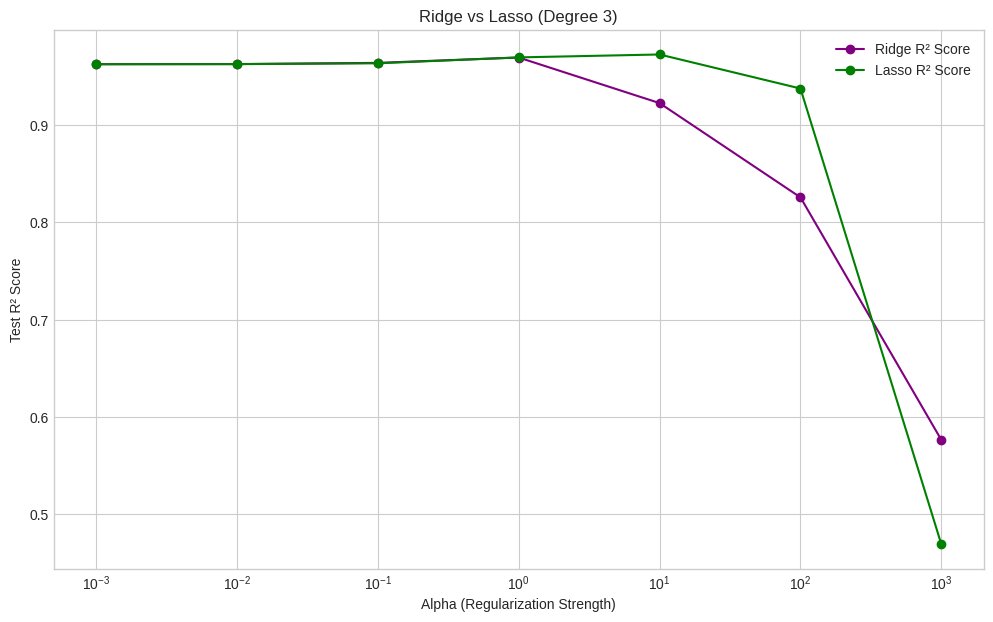

In [60]:
# Pilih derajat polinomial yang cenderung overfitting (Sebagai contoh Degree 3)
degree_to_analyze = 3
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

ridge_scores = []
lasso_scores = []

poly_reg = PolynomialFeatures(degree=degree_to_analyze, include_bias=False)
X_train_poly = poly_reg.fit_transform(X_train_scaled)
X_test_poly = poly_reg.transform(X_test_scaled)

for alpha in alphas:
    # Ridge
    ridge = Ridge(alpha=alpha, max_iter=10000).fit(X_train_poly, y_train)
    ridge_scores.append(r2_score(y_test, ridge.predict(X_test_poly)))

    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000).fit(X_train_poly, y_train)
    lasso_scores.append(r2_score(y_test, lasso.predict(X_test_poly)))

# Plot R² score vs alpha
plt.figure(figsize=(12, 7))
plt.plot(alphas, ridge_scores, 'o-', label='Ridge R² Score', color='purple')
plt.plot(alphas, lasso_scores, 'o-', label='Lasso R² Score', color='green')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Test R² Score')
plt.title(f'Ridge vs Lasso (Degree {degree_to_analyze})')
plt.legend()
plt.grid(True)
plt.show()

Analisis Perbedaan Ridge vs Lasso Regression

Ridge Regression (L2 Regularization):
Performa Ridge terlihat lebih stabil pada berbagai nilai alpha. Ketika alpha meningkat, nilai R² menurun secara perlahan, menunjukkan bahwa Ridge tidak terlalu sensitif terhadap perubahan kekuatan regularisasi.
Ridge bekerja dengan mengecilkan nilai koefisien fitur yang kurang penting, tetapi tidak benar-benar menghilangkannya (tidak menjadi nol). Hal ini membuat Ridge tetap mempertahankan semua fitur, hanya saja dengan pengaruh yang lebih kecil.

Lasso Regression (L1 Regularization):
Lasso menunjukkan performa yang sangat baik pada nilai alpha kecil, namun menurun tajam ketika alpha menjadi terlalu besar.
Berbeda dari Ridge, Lasso mampu melakukan feature selection dengan membuat beberapa koefisien fitur yang tidak relevan menjadi nol sepenuhnya.
Namun, jika nilai alpha terlalu tinggi, Lasso dapat menghapus terlalu banyak fitur, menyebabkan model menjadi underfit dan kehilangan kemampuan prediksi.

B. Feature Importance Analysis

Jumlah fitur asli (setelah polinomial): 55
Jumlah fitur yang dieliminasi oleh Lasso: 5


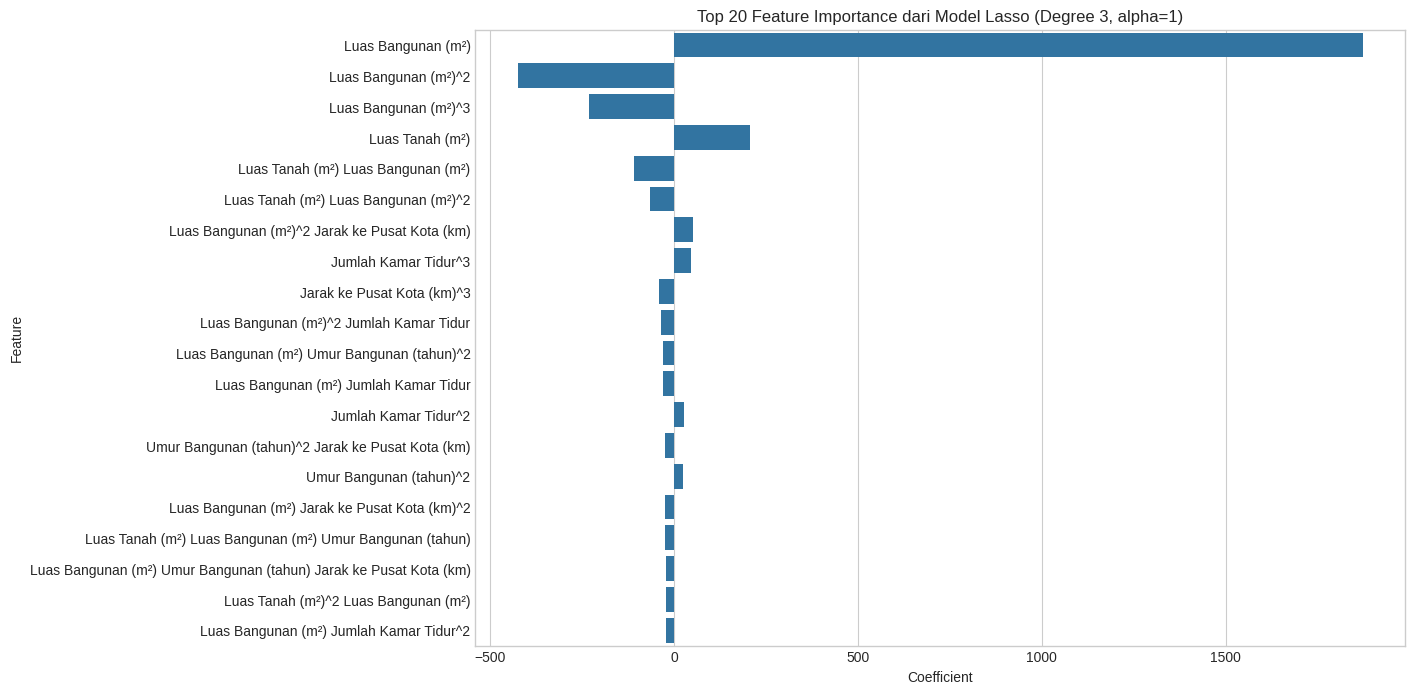

In [61]:
# Train model Lasso dengan alpha optimal (misal, alpha=1) pada Degree 3
poly_reg_3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly_3 = poly_reg_3.fit_transform(X_train_scaled)

lasso_final = Lasso(alpha=1, max_iter=10000).fit(X_train_poly_3, y_train)

# Dapatkan nama fitur polinomial
feature_names = poly_reg_3.get_feature_names_out(X.columns)
coefficients = lasso_final.coef_

# Buat DataFrame untuk analisis
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Fitur yang dieliminasi (koefisien = 0)
eliminated_features = coef_df[coef_df['Coefficient'] == 0]
print(f"Jumlah fitur asli (setelah polinomial): {len(feature_names)}")
print(f"Jumlah fitur yang dieliminasi oleh Lasso: {len(eliminated_features)}")

# Visualisasi 20 fitur paling penting
plt.figure(figsize=(12, 8))
top_20_features = coef_df.head(20)
sns.barplot(x='Coefficient', y='Feature', data=top_20_features)
plt.title('Top 20 Feature Importance dari Model Lasso (Degree 3, alpha=1)')
plt.show()

## 5. Model Selection & Prediction

A. Best Model Selection

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso # Pastikan Lasso sudah di-import

# Kandidat model terbaik yang baru: Degree 3 - Lasso (alpha=10)
best_model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)), # Diubah ke Degree 3
    ('lasso', Lasso(alpha=10, max_iter=10000)) # Diubah ke Lasso dengan alpha=10
])

# K-Fold Cross-Validation (k=10)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model_pipeline, X, y, cv=kf, scoring='r2')

print(f"Hasil Cross-Validation R² Scores (Degree 3 - Lasso): {np.round(cv_scores, 4)}")
print(f"Rata-rata R² Score: {cv_scores.mean():.4f}")
print(f"Standar Deviasi R² Score: {cv_scores.std():.4f}")

Hasil Cross-Validation R² Scores (Degree 3 - Lasso): [0.9748 0.9615 0.978  0.9825 0.9715 0.9785 0.9865 0.9865 0.9859 0.9683]
Rata-rata R² Score: 0.9774
Standar Deviasi R² Score: 0.0080


B. Final Predictions

In [63]:
# Latih ulang model terbaik pada seluruh dataset (X dan y)
final_model = best_model_pipeline.fit(X, y)

# Simpan model terbaik
joblib.dump(final_model, 'best_property_price_model.pkl')
print("Model final berhasil disimpan ke 'best_property_price_model.pkl'")

# Buat fungsi prediksi
def predict_property_price(data_baru):
    # Load model yang sudah dilatih
    model = joblib.load('best_property_price_model.pkl')

    # Lakukan prediksi
    harga_prediksi = model.predict(data_baru)
    return harga_prediksi

# Test dengan 5 data baru (unseen data)
data_baru = pd.DataFrame({
    'Luas Tanah (m²)': [150, 250, 80, 400, 120],
    'Luas Bangunan (m²)': [100, 200, 60, 350, 90],
    'Jumlah Kamar Tidur': [3, 4, 2, 5, 3],
    'Umur Bangunan (tahun)': [5, 1, 15, 2, 10],
    'Jarak ke Pusat Kota (km)': [5, 10, 2, 15, 7]
})

prediksi = predict_property_price(data_baru)

# Tampilkan hasil prediksi
print("\nPrediksi untuk Data Baru ")
hasil_prediksi_df = data_baru.copy()
hasil_prediksi_df['Prediksi Harga (juta Rp)'] = np.round(prediksi, 2)
print(hasil_prediksi_df)

Model final berhasil disimpan ke 'best_property_price_model.pkl'

Prediksi untuk Data Baru 
   Luas Tanah (m²)  Luas Bangunan (m²)  Jumlah Kamar Tidur  \
0              150                 100                   3   
1              250                 200                   4   
2               80                  60                   2   
3              400                 350                   5   
4              120                  90                   3   

   Umur Bangunan (tahun)  Jarak ke Pusat Kota (km)  Prediksi Harga (juta Rp)  
0                      5                         5                   1971.72  
1                      1                        10                   3842.85  
2                     15                         2                   1081.30  
3                      2                        15                   5117.32  
4                     10                         7                   1686.76  
